# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize, Compose


import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

import os
import warnings
import random
import gc
gc.enable()

In [2]:
if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('../')
os.getcwd()

'C:\\Users\\Admin\\Desktop\\Deep Learning\\Domain-Adaptation-Framework'

In [3]:
from src.Models.CNN.base_cnn import CNN
from src.Models.Classifiers.base_classifier import Classifier
from src.Dataset.MNISTM import MNISTM
from src.Tools.model_utils import calculate_model_output_size

In [4]:
device = 'cpu'
seed = 42

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

device

'cpu'

In [6]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Datasets

In [7]:
batch_size = 128
image_size = 32

In [8]:
img_transform_source = Compose([
    Resize(image_size),
    ToTensor(),
    Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = Compose([
    Resize(image_size),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [9]:
src_train_dataset = MNIST('./data', download=False, transform=img_transform_source)
src_test_dataset = MNIST('./data', download=False, train=False, transform=img_transform_source)

src_train_dataset, src_test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [10]:
tgt_train_dataset = MNISTM('./data/MNIST-M', download=False, transform=img_transform_target)
tgt_test_dataset = MNISTM('./data/MNIST-M', download=False, train=False, transform=img_transform_target)

tgt_train_dataset, tgt_test_dataset

./data/MNIST-M\MNISTM\processed\mnist_m_train.pt
./data/MNIST-M\MNISTM\processed\mnist_m_test.pt


(Dataset MNISTM
     Number of datapoints: 60000
     Root location: ./data/MNIST-M
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset MNISTM
     Number of datapoints: 10000
     Root location: ./data/MNIST-M
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [11]:
src_train_loader = DataLoader(
    dataset=src_train_dataset,
    batch_size=batch_size,
    shuffle=True
)
src_test_loader = DataLoader(
    dataset=src_test_dataset,
    batch_size=batch_size,
    shuffle=False
)
tgt_train_loader = DataLoader(
    dataset=tgt_train_dataset,
    batch_size=batch_size,
    shuffle=True
)
tgt_test_loader = DataLoader(
    dataset=tgt_test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Model

In [12]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [32]:
class DANN(nn.Module):    

    def __init__(self, c_in, h_in, w_in, output_size):
        super(DANN, self).__init__()
        
        self.in_c = c_in
        self.feature = CNN(c_in)
        
        c_out, h_out, w_out = calculate_model_output_size(c_in, h_in, w_in, self.feature)
        input_size = c_out * h_out * w_out
        
        self.class_classifier = Classifier(input_size, output_size)

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(input_size, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha=0):
        b, _, w, h = input_data.data.shape
        input_data = input_data.expand(b, self.in_c, w, h)
        
        feature = self.feature(input_data)
        feature = feature.view(b, -1)
        
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

# Training

In [33]:
def test(dataloader, model, device):
    model.eval()

    n_total = 0
    n_correct = 0

    for batch in dataloader:
        t_img, t_label = batch

        batch_size = len(t_label)

        t_img = t_img.float().to(device)
        t_label = t_label.long().to(device)

        class_output, _ = model(t_img)
        pred = class_output.data.max(1, keepdim=True)[1]
        
        n_correct += pred.eq(t_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

    accu = n_correct.data.numpy() * 100.0 / n_total

    return accu

In [34]:
def train(model, optimizer, loss_class, loss_domain, 
          dataloader_source_train, dataloader_target_train, 
          dataloader_source_test, dataloader_target_test, 
          n_epoch, device='cpu', mode='unsupervised', semi=0,
          threshold=20, max_steps=10):
    assert mode in ['unsupervised', 'supervised', 'semi-supervised']
    
    len_dataloader = min(len(dataloader_source_train), len(dataloader_target_train))
    steps = 0
    best_tgt_acc = -1

    src_c_losses = []
    tgt_c_losses = []
    src_d_losses = []
    tgt_d_losses = []
    src_c_accs = []
    tgt_c_accs = []
    total_losses = []

    for epoch in range(1, n_epoch+1):
        sup = mode == 'supervised' or (mode == 'semi-supervised' and random.uniform(0,1) >= semi)
        model.train()

        data_source_iter = iter(dataloader_source_train)
        data_target_iter = iter(dataloader_target_train)

        for i in tqdm(range(len_dataloader)):
            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # training model using source data
            data_source = next(data_source_iter)
            s_img, s_label = data_source

            model.zero_grad()
            batch_size = len(s_label)
            
            s_img = s_img.float().to(device)
            s_label = s_label.long().to(device)
            domain_label = torch.zeros(batch_size, dtype=torch.long).to(device)

            class_output, domain_output = model(s_img, alpha)
            
            err_s_label = loss_class(class_output, s_label)
            err_s_domain = loss_domain(domain_output, domain_label)

            # training model using target data
            data_target = next(data_target_iter)
            t_img, t_label = data_target

            batch_size = len(t_img)
            
            if sup: 
                t_label = t_label.long().to(device)
            else:
                del t_label
            
            t_img = t_img.float().to(device)
            domain_label = torch.ones(batch_size, dtype=torch.long).to(device)

            class_output, domain_output = model(t_img, alpha)
            
            err_t_domain = loss_domain(domain_output, domain_label)
            err_t_label = None
            
            err = err_t_domain + err_s_domain + err_s_label
            if sup:
                err_t_label = loss_class(class_output, t_label)
                err += err_t_label
            
            err.backward()
            optimizer.step()

            if i % 50 == 0:
                src_acc = test(dataloader_source_test, model, device)
                tgt_acc = test(dataloader_target_test, model, device)

                src_c_losses.append(err_s_label.item())
                src_d_losses.append(err_s_domain.item())
                tgt_d_losses.append(err_t_domain.item())
                src_c_accs.append(src_acc)
                tgt_c_accs.append(tgt_acc)
                total_losses.append(err.item())

                msg = f'\nepoch: {epoch}, [iter: {i} / all {len_dataloader}]'
                msg += f'\nerr_s_label: {err_s_label.item():10.4f}'
                msg += f'\nerr_s_domain: {err_s_domain.item():10.4f}'
                if sup:
                    msg += f'\nerr_t_label: {err_t_label.item():10.4f}'
                    tgt_c_losses.append(err_t_label.item())
                else:
                    tgt_c_losses.append(0)

                msg += f'\nerr_t_domain: {err_t_domain.item():10.4f}'

                msg += f'\ntotal err: {err.item():10.4f}'

                msg += f'\nSource test accuracy: {src_acc:3.2f}%'
                msg += f'\nTarget test accuracy: {tgt_acc:3.2f}%'
                
                print(msg)

                if tgt_acc > best_tgt_acc:
                    best_tgt_acc = tgt_acc
                    steps = 0
                else:
                    steps += 1

        if epoch > threshold and steps >= max_steps:
            break

    return src_c_losses, tgt_c_losses, src_d_losses, tgt_d_losses, src_c_accs, tgt_c_accs, total_losses

In [35]:
lr = 1e-3
n_epoch = 1

In [36]:
net = DANN(3, 32, 32, 10)
net.to(device)

print(net)

DANN(
  (feature): CNN(
    (feature): Sequential(
      (f_conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
      (f_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (f_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (f_relu1): ReLU(inplace=True)
      (f_conv2): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
      (f_bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (f_drop1): Dropout2d(p=0.5, inplace=False)
      (f_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (f_relu2): ReLU(inplace=True)
    )
  )
  (class_classifier): Classifier(
    (class_classifier): Sequential(
      (c_fc1): Linear(in_features=1250, out_features=100, bias=True)
      (c_bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c_relu1): ReLU(inplace=True)
      (c_drop1): Dropout2d(p=0.5, inplac

In [37]:
optimizer = optim.Adam(net.parameters(), lr=lr)

loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

In [38]:
result = train(net, optimizer, loss_class, loss_domain, src_train_loader, tgt_train_loader, src_test_loader, tgt_test_loader, n_epoch, device, mode='unsupervised')

  0%|▏                                                                               | 1/469 [00:15<1:58:05, 15.14s/it]


epoch: 1, [iter: 0 / all 469]
err_s_label:     2.3768
err_s_domain:     0.5497
err_t_domain:     0.9172
total err:     3.8437
Source test accuracy: 9.32%
Target test accuracy: 8.92%


 11%|████████▊                                                                        | 51/469 [00:45<31:01,  4.45s/it]


epoch: 1, [iter: 50 / all 469]
err_s_label:     0.7235
err_s_domain:     0.2938
err_t_domain:     0.3901
total err:     1.4075
Source test accuracy: 85.56%
Target test accuracy: 18.44%


 22%|█████████████████▏                                                              | 101/469 [01:14<26:57,  4.39s/it]


epoch: 1, [iter: 100 / all 469]
err_s_label:     0.5262
err_s_domain:     0.2366
err_t_domain:     0.6736
total err:     1.4364
Source test accuracy: 84.66%
Target test accuracy: 36.36%


 32%|█████████████████████████▊                                                      | 151/469 [01:42<23:25,  4.42s/it]


epoch: 1, [iter: 150 / all 469]
err_s_label:     0.5563
err_s_domain:     0.1326
err_t_domain:     0.0252
total err:     0.7141
Source test accuracy: 84.70%
Target test accuracy: 38.93%


 43%|██████████████████████████████████▎                                             | 201/469 [02:11<19:27,  4.36s/it]


epoch: 1, [iter: 200 / all 469]
err_s_label:     0.2076
err_s_domain:     0.0048
err_t_domain:     0.0407
total err:     0.2531
Source test accuracy: 91.80%
Target test accuracy: 38.70%


 54%|██████████████████████████████████████████▊                                     | 251/469 [02:40<15:47,  4.35s/it]


epoch: 1, [iter: 250 / all 469]
err_s_label:     0.2234
err_s_domain:     0.0165
err_t_domain:     0.0406
total err:     0.2805
Source test accuracy: 93.67%
Target test accuracy: 38.98%


 64%|███████████████████████████████████████████████████▎                            | 301/469 [03:09<12:21,  4.41s/it]


epoch: 1, [iter: 300 / all 469]
err_s_label:     0.1845
err_s_domain:     0.0119
err_t_domain:     0.1447
total err:     0.3412
Source test accuracy: 94.71%
Target test accuracy: 41.17%


 75%|███████████████████████████████████████████████████████████▊                    | 351/469 [03:38<08:36,  4.38s/it]


epoch: 1, [iter: 350 / all 469]
err_s_label:     0.5842
err_s_domain:     0.2968
err_t_domain:     0.6236
total err:     1.5046
Source test accuracy: 85.13%
Target test accuracy: 34.33%


 86%|████████████████████████████████████████████████████████████████████▍           | 401/469 [04:09<05:12,  4.59s/it]


epoch: 1, [iter: 400 / all 469]
err_s_label:     0.1670
err_s_domain:     0.1513
err_t_domain:     0.1353
total err:     0.4536
Source test accuracy: 93.06%
Target test accuracy: 40.07%


 96%|████████████████████████████████████████████████████████████████████████████▉   | 451/469 [04:38<01:19,  4.39s/it]


epoch: 1, [iter: 450 / all 469]
err_s_label:     0.1559
err_s_domain:     0.0310
err_t_domain:     0.0610
total err:     0.2479
Source test accuracy: 95.15%
Target test accuracy: 39.54%


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [04:43<00:00,  1.65it/s]


In [39]:
src_c_losses, tgt_c_losses, src_d_losses, tgt_d_losses, src_c_accs, tgt_c_accs, total_losses = result

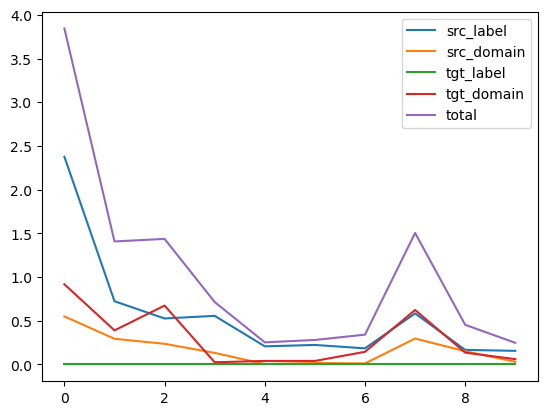

In [40]:
plt.plot(src_c_losses, label='src_label')
plt.plot(src_d_losses, label='src_domain')
plt.plot(tgt_c_losses, label='tgt_label')
plt.plot(tgt_d_losses, label='tgt_domain')
plt.plot(total_losses, label='total')

plt.legend()
plt.show()

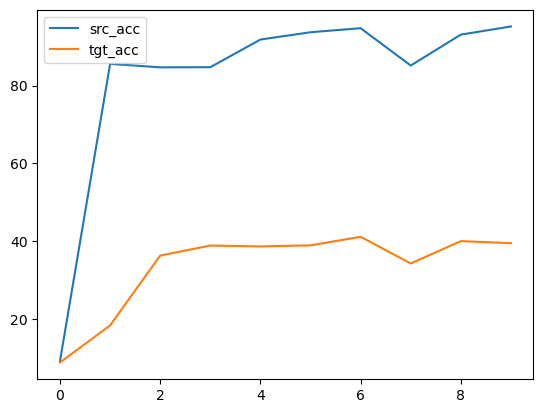

In [41]:
plt.plot(src_c_accs, label='src_acc')
plt.plot(tgt_c_accs, label='tgt_acc')

plt.legend()
plt.show()

torch.Size([128, 50, 5, 5])

In [ ]:
net.class_classifier